In [39]:
# === Step 1: Setup awal ===
!nvidia-smi   # cek GPU
import torch
print("CUDA available:", torch.cuda.is_available())

Mon Sep 22 08:24:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             30W /   70W |    1378MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [40]:
# upload dataset
from google.colab import files
uploaded = files.upload()

# Extract dataset.zip
import zipfile
import os

zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")

KeyboardInterrupt: 

In [42]:
print("Isi folder:", os.listdir("."))

Isi folder: ['.config', 'Machine-Learning-Project---egg-classification-with-cnn-algorithm', '.ipynb_checkpoints', 'dataset', '.gradio', 'dataset.zip', 'sample_data']


In [41]:
# === Step 3: Import Library ===
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [43]:
# Parameters
img_size = 224
batch_size = 32
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
# Data Augmentation & Normalization
train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [45]:
# Dataset path
train_dir = "dataset/train"
val_dir = "dataset/valid"

train_data = datasets.ImageFolder(train_dir, transform=train_tf)
val_data = datasets.ImageFolder(val_dir, transform=val_tf)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [46]:
print("Kelas:", train_data.classes)

Kelas: ['egg', 'not egg']


In [47]:
# === Step 4: Model Transfer Learning ResNet18 ===
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 kelas: egg / not_egg
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
# === Step 5: Training Loop ===
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    # === Training ===
    model.train()
    running_loss, running_corrects = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects / len(train_data)

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # === Validation ===
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * imgs.size(0)
            val_running_corrects += torch.sum(preds == labels).item()

    val_loss = val_running_loss / len(val_data)
    val_acc = val_running_corrects / len(val_data)

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 0.3609 | Train Acc: 0.8564 | Val Loss: 0.6459 | Val Acc: 0.8500
Epoch 2/10 | Train Loss: 0.0902 | Train Acc: 0.9641 | Val Loss: 26.2859 | Val Acc: 0.4500
Epoch 3/10 | Train Loss: 0.1858 | Train Acc: 0.9795 | Val Loss: 6.8546 | Val Acc: 0.7000
Epoch 4/10 | Train Loss: 0.1135 | Train Acc: 0.9744 | Val Loss: 1.6317 | Val Acc: 0.8500
Epoch 5/10 | Train Loss: 0.0207 | Train Acc: 1.0000 | Val Loss: 1.7351 | Val Acc: 0.8000
Epoch 6/10 | Train Loss: 0.0463 | Train Acc: 0.9846 | Val Loss: 1.6437 | Val Acc: 0.8000
Epoch 7/10 | Train Loss: 0.0253 | Train Acc: 1.0000 | Val Loss: 0.3624 | Val Acc: 0.8500
Epoch 8/10 | Train Loss: 0.0839 | Train Acc: 0.9897 | Val Loss: 0.8869 | Val Acc: 0.7500
Epoch 9/10 | Train Loss: 0.1874 | Train Acc: 0.9333 | Val Loss: 1.8893 | Val Acc: 0.6000
Epoch 10/10 | Train Loss: 0.1448 | Train Acc: 0.9538 | Val Loss: 0.6587 | Val Acc: 0.8500


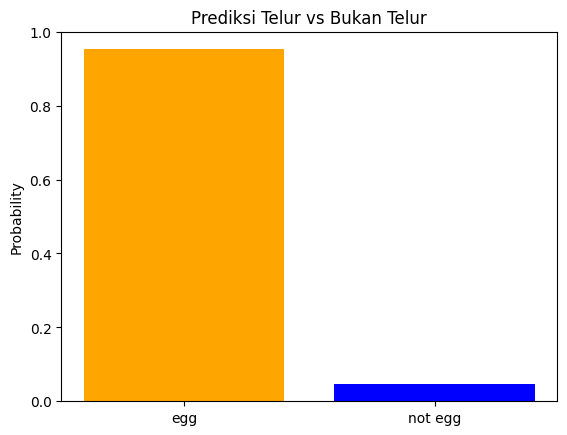

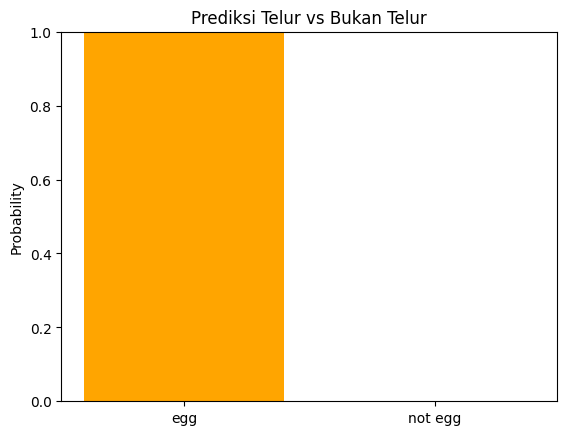

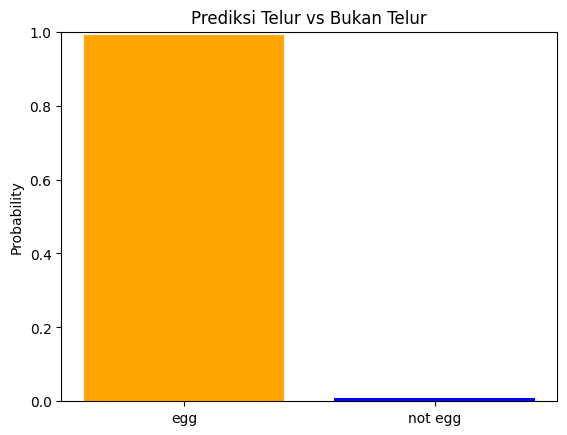

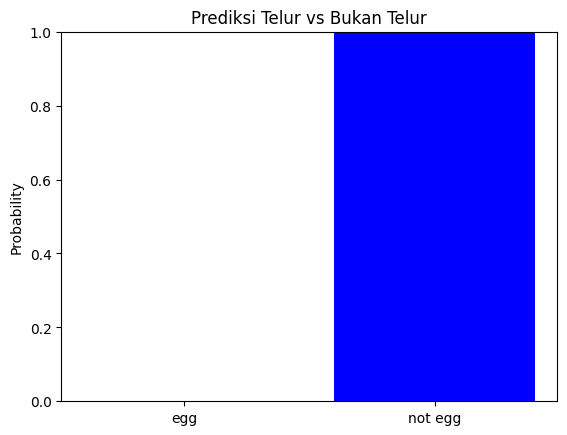

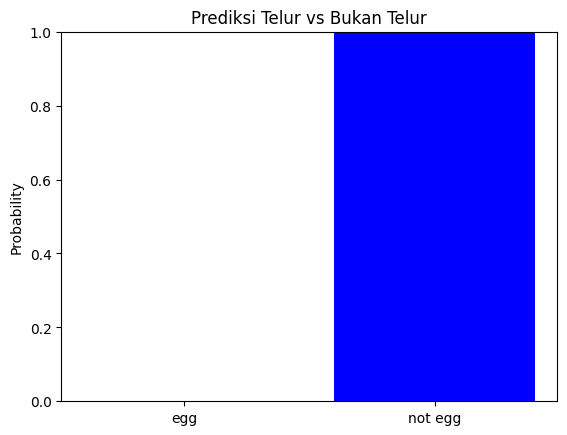

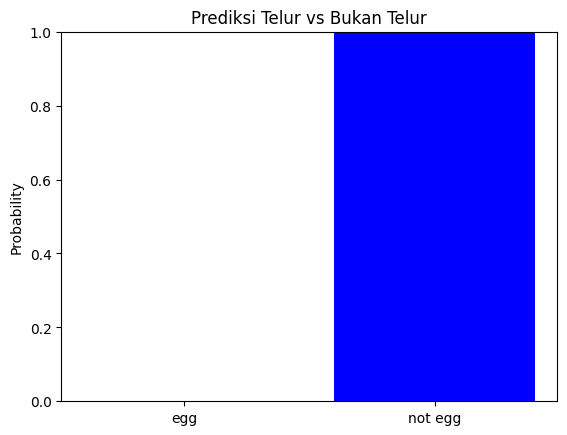

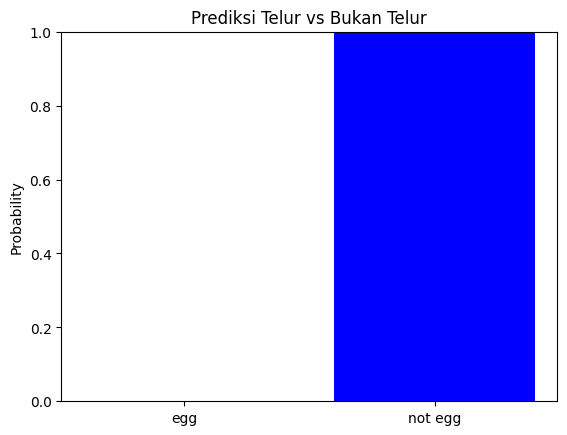

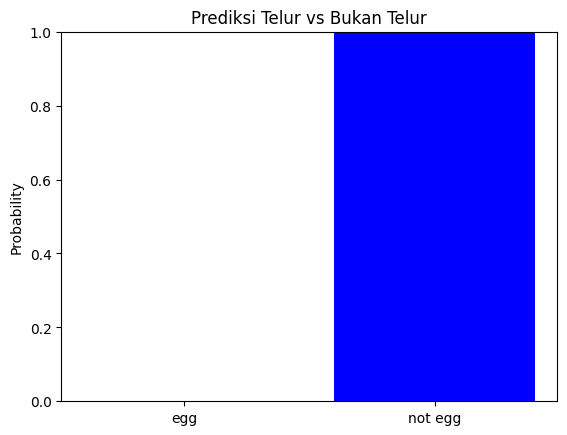

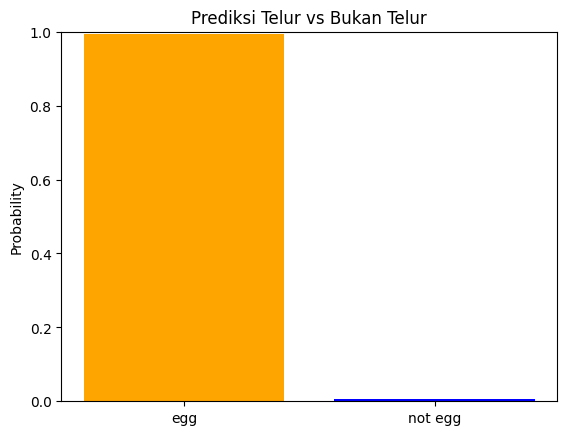

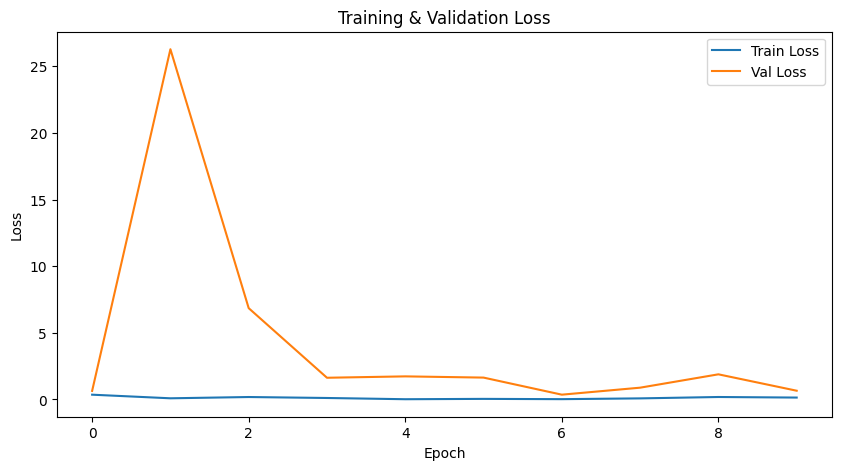

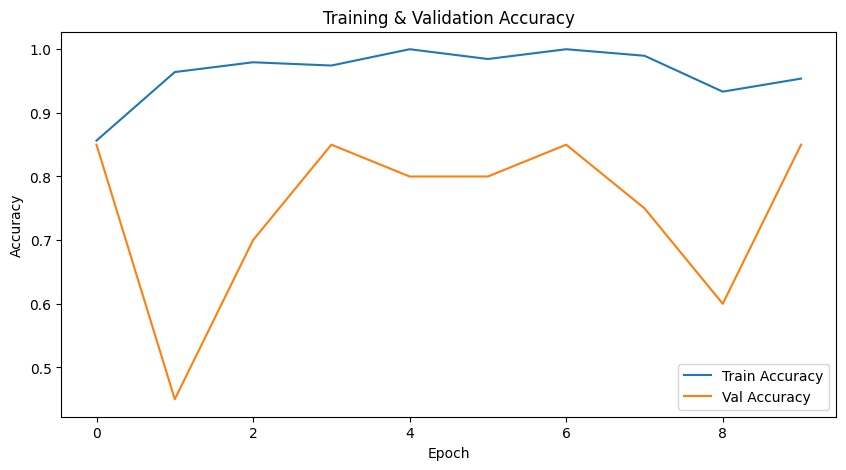

In [49]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()


In [50]:
# === Step 6: Save Model ===
torch.save(model.state_dict(), "egg_detector.pth")
print("Model saved")

Model saved


In [52]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Fungsi prediksi + visualisasi grafik
def predict_with_plot(img):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img = Image.fromarray(img).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)[0].cpu().numpy()

    # --- Buat bar chart ---
    fig, ax = plt.subplots()
    ax.bar(train_data.classes, probs, color=["orange", "blue"])
    ax.set_ylim([0, 1])
    ax.set_ylabel("Probability")
    ax.set_title("Prediksi Telur vs Bukan Telur")

    # Convert matplotlib figure to image
    return {train_data.classes[i]: float(probs[i]) for i in range(len(probs))}, fig

# Buat UI Gradio
demo = gr.Interface(
    fn=predict_with_plot,
    inputs=gr.Image(type="numpy", label="Upload Gambar"),
    outputs=[
        gr.Label(num_top_classes=2, label="Hasil Prediksi"),
        gr.Plot(label="Visualisasi Probabilitas")
    ],
    title="Deteksi Telur vs Bukan Telur"
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a991b1e4a2e1afb80f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [53]:
!git clone https://github.com/Andrianmusthofany/Machine-Learning-Project---egg-classification-with-cnn-algorithm

fatal: destination path 'Machine-Learning-Project---egg-classification-with-cnn-algorithm' already exists and is not an empty directory.


In [54]:
!mv egg_detector.pth Machine-Learning-Project---egg-classification-with-cnn-algorithm

In [58]:
!mv prediksi_cnn.ipynb Machine-Learning-Project---egg-classification-with-cnn-algorithm

mv: cannot stat 'prediksi_cnn.ipynb': No such file or directory
